In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
writer = SummaryWriter('runs/cifar10_resnet9')

In [2]:
BATCH_SIZE = 64

transform = transforms.Compose(
    [transforms.Pad(4),
     transforms.RandomCrop(32),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#      transforms.RandomErasing(p=0.5,scale=(0.1, 0.1), ratio=(1,1))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


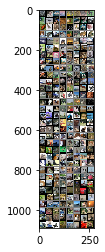

truck   dog  ship  ship


In [3]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid)
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
device = torch.device("cuda")

print(device)

cuda


In [19]:
from torchvision.models.resnet import BasicBlock
net = torchvision.models.ResNet(BasicBlock, [1, 1, 1, 1])
net.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
net.fc = nn.Linear(512,10)
net.to(device)
net.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [6]:
writer.add_graph(net,images.to(device))
writer.close()

NameError: name 'writer' is not defined

In [20]:
epochs = 40
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay= 5e-4 * BATCH_SIZE)
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay= 5e-4 * BATCH_SIZE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)

In [21]:
from torch.optim.lr_scheduler import _LRScheduler

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class LRFinder():
    def __init__(self, model, optimizer, criterion, device):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.device = device
        
    def find_lr(self, trainloader, end_lr, num_iter, step_mode="exp", smooth_f=0.05):
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        if step_mode == "exp":
            lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode == "linear":
            # todo
            pass
        
        self.model = self.model.to(device)
        
        iterator = iter(trainloader)
        for iteration in range(num_iter):
            try:
                inputs, labels = next(iterator)
            except StopIteration:
                iterator = iter(trainloader)
                inputs, labels = next(iterator)
            inputs, labels = inputs.to(device), labels.to(device)
            self.optimizer.zero_grad()
            
            outputs = self.model(inputs)
            
            loss = self.criterion(outputs, labels)
            loss.backward()
            
            self.optimizer.step()
            lr_scheduler.step()
            
            self.history["lr"].append(lr_scheduler.get_lr()[0])
            self.history["loss"].append(loss)
            
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss
                    
        print("finish")
        
    def plot(self):
        lrs = self.history["lr"]
        losses = self.history["loss"]

        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning rate(log scale)")
        plt.ylabel("Loss")
        plt.show()

finish


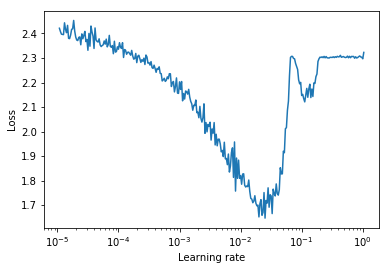

In [22]:
lr_finder = LRFinder(net, optimizer, criterion, torch.device("cuda"))
lr_finder.find_lr(trainloader, 1, 300)
lr_finder.plot()

In [112]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step(epoch)

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            
            writer.add_scalar('training loss', running_loss / 200,
                              (epoch-1) * len(trainloader) + i)
            
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 2.057
[1,   400] loss: 1.763
[1,   600] loss: 1.610
[2,   200] loss: 1.442
[2,   400] loss: 1.394
[2,   600] loss: 1.339
[3,   200] loss: 1.234
[3,   400] loss: 1.203
[3,   600] loss: 1.171
[4,   200] loss: 1.093
[4,   400] loss: 1.091
[4,   600] loss: 1.048
[5,   200] loss: 1.001
[5,   400] loss: 0.981
[5,   600] loss: 0.975
[6,   200] loss: 0.920
[6,   400] loss: 0.899
[6,   600] loss: 0.891
[7,   200] loss: 0.861
[7,   400] loss: 0.851
[7,   600] loss: 0.830
[8,   200] loss: 0.817
[8,   400] loss: 0.804
[8,   600] loss: 0.805
[9,   200] loss: 0.772
[9,   400] loss: 0.786
[9,   600] loss: 0.767
[10,   200] loss: 0.757
[10,   400] loss: 0.738
[10,   600] loss: 0.746
[11,   200] loss: 0.721
[11,   400] loss: 0.718
[11,   600] loss: 0.733
[12,   200] loss: 0.714
[12,   400] loss: 0.694
[12,   600] loss: 0.704
[13,   200] loss: 0.684
[13,   400] loss: 0.676
[13,   600] loss: 0.677
[14,   200] loss: 0.683
[14,   400] loss: 0.657
[14,   600] loss: 0.674
[15,   200] loss: 0

In [114]:
PATH = './cifar_resnet9_90%.pth'
torch.save(net.state_dict(), PATH)

In [117]:
def test(net, weight_path, trainloader, testloader):
#     net.load_state_dict(torch.load(weight_path))
    device = torch.device("cuda")
    net.to(device)
    correct = 0
    total = 0
    
    net.eval()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50000 train images: %d %%' % (
        100 * correct / total))
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [118]:
test(net, None, trainloader, testloader)

Accuracy of the network on the 50000 train images: 96 %
Accuracy of the network on the 10000 test images: 90 %
Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 84 %
Accuracy of   cat : 80 %
Accuracy of  deer : 87 %
Accuracy of   dog : 77 %
Accuracy of  frog : 91 %
Accuracy of horse : 90 %
Accuracy of  ship : 94 %
Accuracy of truck : 93 %
